*Note: You are currently reading this using Google Colaboratory which is a cloud-hosted version of Jupyter Notebook. This is a document containing both text cells for documentation and runnable code cells. If you are unfamiliar with Jupyter Notebook, watch this 3-minute introduction before starting this challenge: https://www.youtube.com/watch?v=inN8seMm7UI*

---

In this challenge, you will predict healthcare costs using a regression algorithm.

You are given a dataset that contains information about different people including their healthcare costs. Use the data to predict healthcare costs based on new data.

The first two cells of this notebook import libraries and the data.

Make sure to convert categorical data to numbers. Use 80% of the data as the `train_dataset` and 20% of the data as the `test_dataset`.

`pop` off the "expenses" column from these datasets to create new datasets called `train_labels` and `test_labels`. Use these labels when training your model.

Create a model and train it with the `train_dataset`. Run the final cell in this notebook to check your model. The final cell will use the unseen `test_dataset` to check how well the model generalizes.

To pass the challenge, `model.evaluate` must return a Mean Absolute Error of under 3500. This means it predicts health care costs correctly within $3500.

The final cell will also predict expenses using the `test_dataset` and graph the results.

### My Update

See [bottom of notebook](#Run-Once) for steps to ensure tensorflow_docs and CSV data file are setup correctly.

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

from sklearn.model_selection import train_test_split

In [33]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error [Y]')
  plt.legend()
  plt.grid(True)

In [63]:
df = pd.read_csv('data/insurance.csv')
df

,age,sex,bmi,children,smoker,region,expenses
0,19,female,27.9,0,yes,southwest,16884.92
1,18,male,33.8,1,no,southeast,1725.55
2,28,male,33.0,3,no,southeast,4449.46
3,33,male,22.7,0,no,northwest,21984.47
4,32,male,28.9,0,no,northwest,3866.86
...,...,...,...,...,...,...,...
1333,50,male,31.0,3,no,northwest,10600.55
1334,18,female,31.9,0,no,northeast,2205.98
1335,18,female,36.9,0,no,southeast,1629.83
1336,21,female,25.8,0,no,southwest,2007.95


## Resources

* https://www.tensorflow.org/tutorials/keras/regression
* https://www.tensorflow.org/tutorials/estimator/linear


In [64]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
age,1338.0,39.207025,14.049960,18.00,27.0000,39.00,51.000,64.00
bmi,1338.0,30.665471,6.098382,16.00,26.3000,30.40,34.700,53.10
children,1338.0,1.094918,1.205493,0.00,0.0000,1.00,2.000,5.00
expenses,1338.0,13270.422414,12110.011240,1121.87,4740.2875,9382.03,16639.915,63770.43


In [8]:
df.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
expenses    0
dtype: int64

In [131]:
# See for reference: https://www.tensorflow.org/tutorials/keras/regression
dataset = df.copy()

categorical_columns = ["sex", "smoker", "region", "children"]
dataset = pd.get_dummies(dataset, columns = categorical_columns, drop_first=False)

train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

train_labels = train_dataset.pop("expenses")
test_labels = test_dataset.pop("expenses")
labels = dataset.pop("expenses")

train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
age,1070.0,39.036449,14.142122,18.0,26.0,39.0,51.0,64.0
bmi,1070.0,30.737290,6.065193,16.0,26.3,30.5,34.8,53.1
sex_female,1070.0,0.501869,0.500230,0.0,0.0,1.0,1.0,1.0
sex_male,1070.0,0.498131,0.500230,0.0,0.0,0.0,1.0,1.0
smoker_no,1070.0,0.800935,0.399484,0.0,1.0,1.0,1.0,1.0
smoker_yes,1070.0,0.199065,0.399484,0.0,0.0,0.0,0.0,1.0
region_northeast,1070.0,0.248598,0.432402,0.0,0.0,0.0,0.0,1.0
region_northwest,1070.0,0.235514,0.424518,0.0,0.0,0.0,0.0,1.0
region_southeast,1070.0,0.281308,0.449848,0.0,0.0,0.0,1.0,1.0
region_southwest,1070.0,0.234579,0.423934,0.0,0.0,0.0,0.0,1.0


CPU times: total: 9.64 s
Wall time: 8.19 s


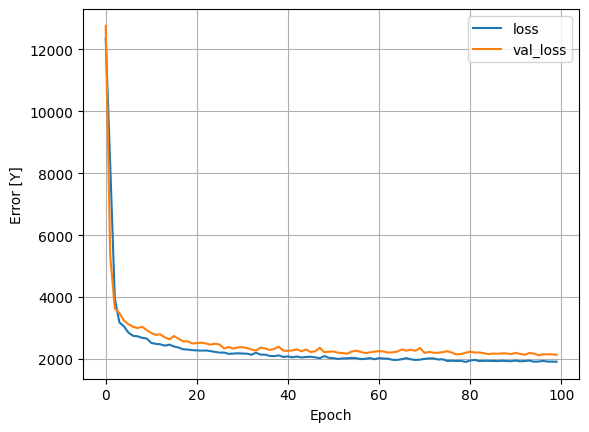

In [153]:
%%time

metrics = [tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.MeanSquaredError()]

normalizer = tf.keras.layers.Normalization(axis=1)
normalizer.adapt(np.array(dataset))
sequence = [
    normalizer, 
    layers.Dense(units=10, activation="relu"),
    layers.Dense(units=5, activation="relu"), 
    layers.Dense(units=1, activation="linear")
]
model = tf.keras.Sequential(sequence)
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.1), 
    loss = tf.keras.losses.MeanAbsoluteError(),
    metrics = metrics)

history = model.fit(
    train_dataset,
    train_labels,
    epochs = 100,
    verbose = 0,
    validation_split = 0.2)

plot_loss(history)

9/9 - 0s - loss: 2745.4529 - mean_absolute_error: 2745.4529 - mean_squared_error: 36025368.0000 - 51ms/epoch - 6ms/step
Testing set Mean Abs Error: 2745.45 expenses
You passed the challenge. Great job!
9/9 [==============================] - 0s 1ms/step


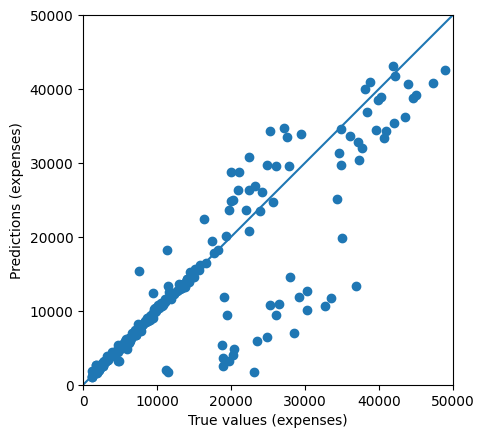

In [154]:
# RUN THIS CELL TO TEST YOUR MODEL. DO NOT MODIFY CONTENTS.
# Test model by checking how well the model generalizes using the test set.
loss, mae, mse = model.evaluate(test_dataset, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} expenses".format(mae))

if mae < 3500:
  print("You passed the challenge. Great job!")
else:
  print("The Mean Abs Error must be less than 3500. Keep trying.")

# Plot predictions.
test_predictions = model.predict(test_dataset).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True values (expenses)')
plt.ylabel('Predictions (expenses)')
lims = [0, 50000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims,lims)


# Run Once

## Setup Environment

Here we can ensure the tensorflow_docs package is installed and data file downloaded.

In [1]:
# Import libraries. You may or may not use all of these.
!pip install -q git+https://github.com/tensorflow/docs


[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Import data -- Modified for Windows and using Python libraries since wget is not universal
import requests
import os

url = "https://cdn.freecodecamp.org/project-data/health-costs/insurance.csv"
filename = os.path.join("data", os.path.basename(url))
with open(filename , 'wb') as fh:
    fh.write(requests.get(url).content)
